In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_clean.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

In [3]:
artists = pd.read_json('data/artists_clean.json')

In [4]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

## Do I prefer to discover new music or stick with known songs?

Do I have any go-to songs? artists? A go-to song is a song...

Do I have any hidden favorite songs? artists?

How much of my collection is from artists from my list of top artists?

The top 1% of artists ($n=40$) make up 27% of songs in my history, the top 5% of artists ($n=201$) make up 52% of songs, the top 10% of artists ($n=403$) make up 66% of songs, and the top 25% of artists ($n=1007$) make up 82% of songs.

In [13]:
makeup = []
brackets = [0.01]#, 0.05, 0.1, 0.25]

sort_artist_df = artists.sort_values('listens', ascending=False)

for portion in brackets:
    
    top_portion = round(len(sort_artist_df) * portion)
    top_portion = sort_artist_df.iloc[:top_portion, 0]
        
    total_songs_in_portion = 0
    for row in full_history.itertuples():
        # for each track, look through the artists
        for artist in row.artists:
            print(artist)
            # if at least one artist on the song is in the top portion, count it and skip the rest
            if artist in list(top_portion):
                total_songs_in_portion += 1                
                break
        break
            
    makeup.append([len(top_portion), total_songs_in_portion / len(full_history)])
    
makeup = np.array(makeup)

2YZyLoL8N0Wb9xBt1NhZWg


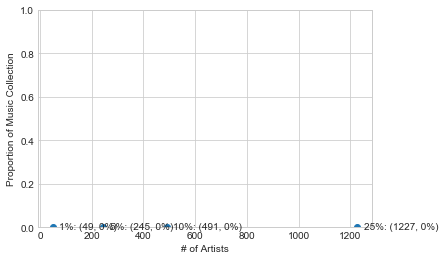

In [7]:
plt.scatter(x=makeup[:, 0], y=makeup[:, 1])

for i, elm in enumerate(makeup):
    plt.annotate('{}%: ({}, {}%)'.format(int(brackets[i]*100), int(elm[0]), int(elm[1]*100)), 
                 (elm[0], elm[1]), (elm[0]+25, elm[1]-0.01))

plt.xlabel('# of Artists')
plt.ylabel('Proportion of Music Collection')
plt.ylim([0,1]);

54.9% of artists I've listened to, I've only listened to once!

In [14]:
len(sort_artist_df[sort_artist_df['listens'] == 1])/len(sort_artist_df)

0.547881010594947

# Is my music collection mainstream?

Compared to what most people are listening to, am I any different? (I'd like to think so, but we'll see)

In [ ]:
mainstream = pd.read_json('data/mainstream_music.json')

In [ ]:
mainstream['tempo'] = mainstream['tempo'].apply(round)
mainstream['tempo'] = mainstream['tempo'].apply(lambda x: x if x < 168 else x/2)

In [ ]:
#hist(mainstream['tempo'], [65,170])
sns.distplot(mainstream['tempo'])
full_history['tempo'].describe()

In [ ]:
mainstream['duration'] = mainstream['duration_ms'] / 1000 / 60
mainstream = mainstream.drop('duration_ms', axis=1)

In [ ]:
hist(mainstream['duration'], [2,8], 21)
print(mainstream['duration'].describe())